# Limiting current & voltage models
Wednesday 22nd November 2023

### Before we start:

- Execute each block of code by pressing the Shift + Return
- Lines preceded with a # are comments and included to help you understand the code.
- Python is fussy about indents so if you change the code, keep the code indented as shown.

## Trivich-Flinn Efficiency limit
In 1955 Trivich & Flinn published a model for limiting efficiency.  The limit it
produces is too high, but it represents a good place to  start with a computer model.

_Trivich D, Flinn PA. Maximum efﬁciency of solar energy conversion by quantum processes. In Solar Energy Research, Daniels F, Dufﬁe J (eds). Thames and Hudson: London, 1955._

Trivich & Flinn assumed that the ideal solar cell would absorb all photons with
energy above the band-gap energy $E_g$ and that the _maximum_ voltage that could ever
be attained in a solar cell is the band-gap energy.  The latter assumption is incorrect unless the solar cell is operating at absolute zero temperature.

To develop a model for the Trivich & Flinn efficiency limit the first step is to
calculate what the limit to the photocurrent is in a solar cell.

## Limits to the short-circuit current

### Solar Spectrum

The solar spectrum defines the ultimate current that a solar cell can produce.  First we will plot the AM1.5G solar spectrum $b(\lambda)$ as a spectral irradiance, meaning that the y-axis has units of $W.m^{-2}.nm^{-1}$

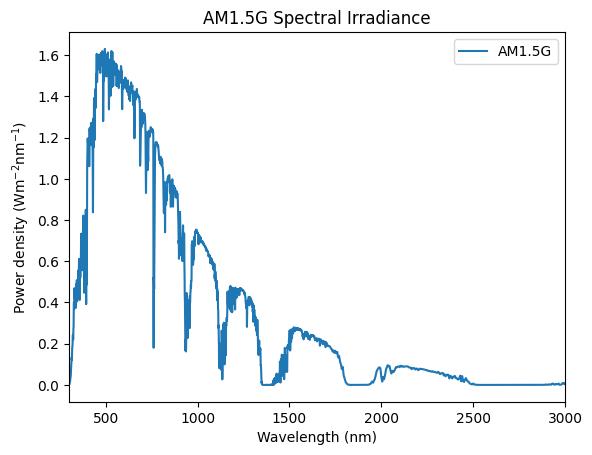

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from solcore.light_source import LightSource
import seaborn as sns

# Setup the AM1.5G solar spectrum
wl = np.linspace(300, 4000, 4000) * 1e-9    # wl contains the x-coordinate in wavelength
am15g = LightSource(source_type='standard', x=wl*1e9, version='AM1.5g',
                    output_units="power_density_per_nm")

plt.figure()
plt.title('AM1.5G Spectral Irradiance')
plt.plot(*am15g.spectrum(wl*1e9), label='AM1.5G')
plt.xlim(300, 3000)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Power density (Wm$^{-2}$nm$^{-1}$)')
plt.legend()

Let us now integrate the solar spectrum to provide the total irradiance in units of \[$W.m^{-2}$\].  The code below performs the following operation $b=\int^{\infty}_{0} b(\lambda) d\lambda$

In [2]:
# Since .spectrum function returns a tuple (x,y) but np.trapz requires data in format (y,x) these are extracted into separate 1D np arrays.
yval = am15g.spectrum()[1]
xval = am15g.spectrum()[0]
integrated_value = np.trapz(yval,xval)  # Perform integration using trapezium rule
b = integrated_value  # Save the integrated power density for the sun for later.
print('b = ', integrated_value)

b =  1000.3974821197136


Let's take the opportunity to learn how to format numbers nicely in Python.  Here we use  the command "%.0f" % to display the value to zero decimal places.

In [3]:
print('b = ',"%.0f" % integrated_value,"W.m-2")

b =  1000 W.m-2


Solcore performs this integration for us internally.  Let's try the same exercise but for the extraterrestrial solar spectrum, AM0

In [4]:
am0 = LightSource(source_type='standard', x=wl*1e9, version='AM0')
print("AM0 integrates to", "%.0f" % am0.power_density, "W.m-2")

AM0 integrates to 1348 W.m-2


### Spectral Photon Flux

To calculate a short-circuit current it is convenient to change the units.  Two changes are necessary :
 1. Since we specify band-gap energies in electron volts (eV) we need to transform the x-axis from nm to eV
2. Photocurrent is proportional to the incident photon flux (number of photons per second) not the irradiance (watts) so we need to convert the y-axis from energy to photon number.

Note: The conversion is performed internally within the software but be aware that because the transformation from wavelength is non-linear, changing the x-axis from nm to eV also changes the y-values of the data. This is known as a Jacobian transformation and discussed in more detail in an article ["Getting the basics right: Jacobian Conversion of Wavelength and Energy Scales for Quantatitive Analysis of Emission Spectra", Journal of Physical Chemistry, 4(19) 3316 (2013)](http://pubs.acs.org/doi/abs/10.1021/jz401508t)

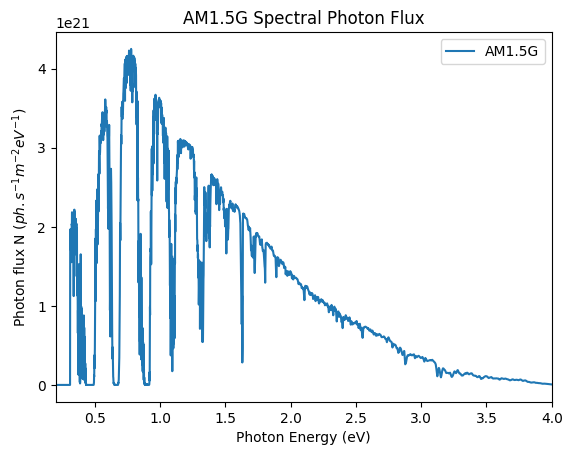

In [5]:
ev = np.linspace(0.02,4,4000)
flux = LightSource(source_type='standard', version='AM1.5g', x=ev, output_units='photon_flux_per_ev')

plt.figure()
plt.title('AM1.5G Spectral Photon Flux')
plt.plot(*flux.spectrum(), label='AM1.5G')
plt.xlim(0.2, 4)
plt.xlabel('Photon Energy (eV)')
plt.ylabel('Photon flux N ($ph.s^{-1}m^{-2}eV^{-1}$)')
plt.legend()

### Calculating the short-circuit current

Integrating the photon flux can provide an upper limit to the short-circuit current [$A.m^{-2}$]. We can integrate the spectrum over the entire spectral range using $J_{sc}=q\int_{0}^{\infty}N(E)dE$

In [6]:
q = 1.60217662E-19
yval = flux.spectrum()[1]
xval = flux.spectrum()[0]
yint = q*np.trapz(yval,xval)  # Perform integration using trapezium rule

print("%.0f" % yint)

690


A more useful calculation is to calculate the current that a solar cell would produce
 with a particular band-gap energy.  To do this requires a bit more coding, since we now wish to integrate between limits:  $J_{sc}=q\int_{Eg}^{\infty}N(E)dE$

Let's do this for a band-gap of 1.42 eV:


In [7]:
q = 1.60217662E-19
eg = 1.42
yval = flux.spectrum()[1]
xval = flux.spectrum()[0]

yval[xval < eg] = 0 # set photon flux to zero for photon energies below the band-gap

yint = q*np.trapz(yval,xval)  # Perform integration using trapezium rule

print("%.0f" % yint)

321


Let's reproduce the $J_{sc}$ vs $E_g$ graph that is shown on p. 87 of Martin Green's
Solar Cells book:

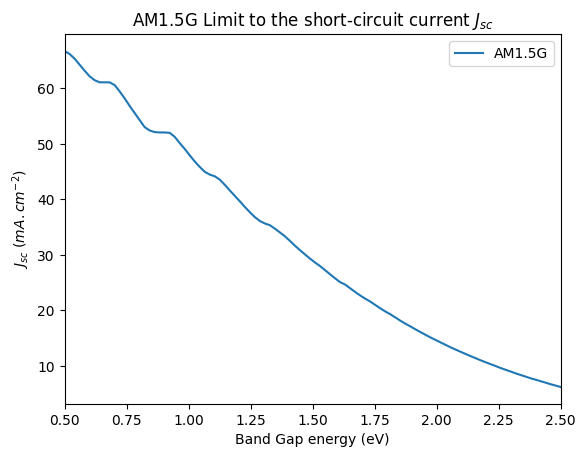

In [8]:
q = 1.60217662E-19

def getJsc(eg):
    yval = flux.spectrum()[1]  # Start with the solar spectrum in yval & xval
    xval = flux.spectrum()[0]
    yval[xval < eg] = 0 # set photon flux to zero for photon energies below the band-gap
    return q*np.trapz(yval,xval)  # return the integrated value

eg = np.linspace(0.5,2.5,100)
jsc = np.vectorize(getJsc)(eg)

plt.figure()
plt.title('AM1.5G Limit to the short-circuit current $J_{sc}$')
plt.plot(eg, jsc/10, label='AM1.5G')  # Divide by 10 to convert from A.m^-2 to mA.cm^-2
plt.xlim(0.5, 2.5)
plt.xlabel('Band Gap energy (eV)')
plt.ylabel('$J_{sc}$ ($mA.cm^{-2}$)')
plt.legend()

### Calculating the Trivich-Flinn Efficiency limit

Now that the limit to $J_{sc}$ is known, we can estimate the power of delivered by the
solar cell by evaluating $\frac{Eg J_{sc}}{b}$

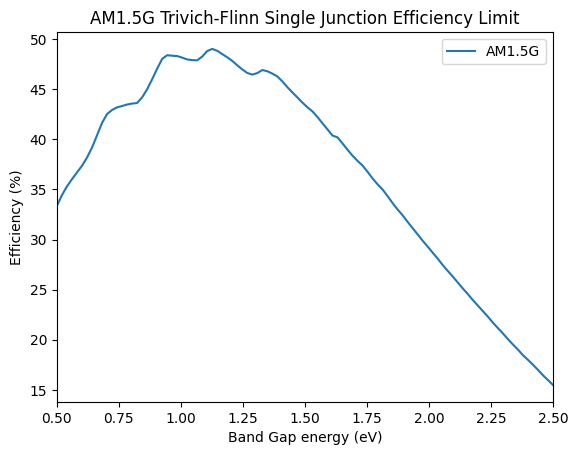

In [9]:
plt.figure()
plt.title('AM1.5G Trivich-Flinn Single Junction Efficiency Limit')
plt.plot(eg, 100*eg*jsc/b,label='AM1.5G')  # Divide by 10 to convert from A.m^-2 to mA.cm^-2
plt.xlim(0.5, 2.5)
plt.xlabel('Band Gap energy (eV)')
plt.ylabel('Efficiency (%)')
plt.legend()

## The Shockley-Queisser Efficiency limit

In Shockley & Queisser published an important refinement to the Trivich-Flinn limit by linking the voltage a solar cell can deliver to the Fermi level separation in the conduction and valance bands, not the band-gap energy.
[Shockley, William, & Queisser, Hans J. ’Detailed Balance Limit of Efficiency of p-n Junction Solar Cells’. Journal of Applied Physics, 32(3) (1961) 510](https://doi.org/10.1063/1.1736034)

To do this, a model is required for the recombination processes between the conduction and valance bands.  The most fundamental (and inescapable) recombination mechanism is the radiative process.  In section 3 we will derive a limit to Shockley's diode equation $J=J_0 e^{\frac{V}{kT}}$ for the radiative limit, that being a diode where all current flows are linked to an optical process, either absorption or recombination.  

In the radiative limit and an abrupt band-edge at band-gap energy $E_g$ it can be shown that $J_0$ is approximated by $J_0=q \frac{2 \pi}{c^2 h^3} kT \left(E_g^2+2 E_g k T+2 k^2 T^2\right) e^{\frac{-E_g}{k T}}$

We can now plot a chart of $J_0$ as a function of band-gap energy using this expression:

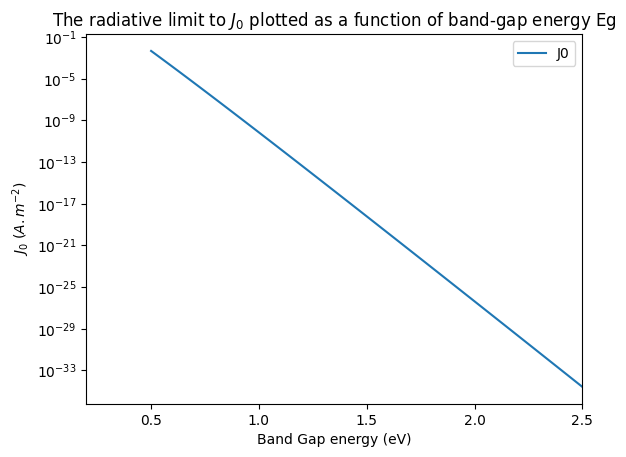

In [10]:
# Define some physical constants:
q = 1.60217662E-19  # electronic charge [C]
k = 1.38064852E-23/q   # Boltzmann constant [eV/K]
h = 6.62607004E-34/q  # Planck constant expressed in [eV.s]
c = 299792458  # Speed of light [m.s^-1]

t = 300  # Perform the calculation for a solar cell at 300K.

# Define a function to return J0 implementing the expression above
def getJ0(eg):
    return k*t*q*(2*np.pi/(c**2*h**3))*(eg**2+2*eg*k*t+2*k**2*t**2)*np.exp(-eg/(k*t))

eg = np.linspace(0.5,2.5,100)
j0 = np.vectorize(getJ0)(eg)

plt.figure()
plt.title('The radiative limit to $J_0$ plotted as a function of band-gap energy Eg')
plt.plot(eg,j0,label='J0')  # Divide by 10 to convert from A.m^-2 to mA.cm^-2
plt.xlim(0.2, 2.5)
plt.xlabel('Band Gap energy (eV)')
plt.ylabel('$J_{0}$ ($A.m^{-2}$)')
plt.yscale("log")
plt.legend()

Let's obtain J0 for GaAs and InGaP, two common III-V materials that are used in tandem solar cells:  evaluate getJ0() for Eg=1.42 and Eg=1.88

In [11]:
getJ0(1.42)

1.195457897843886e-17

In [12]:
getJ0(1.88)

3.888154629395649e-25

## Calculating the IV curve

We are now able to calculate the limiting efficiency for a solar cell using the simple Shockley diode expression $J(V)=J_{s c}-J_0\left(e^{\frac{q V}{k T}}-1\right)$.  Let's plot the IV curve for a band-gap of 1.42eV

Text(0, 0.5, 'Current ($mA.cm^{-2}$)')

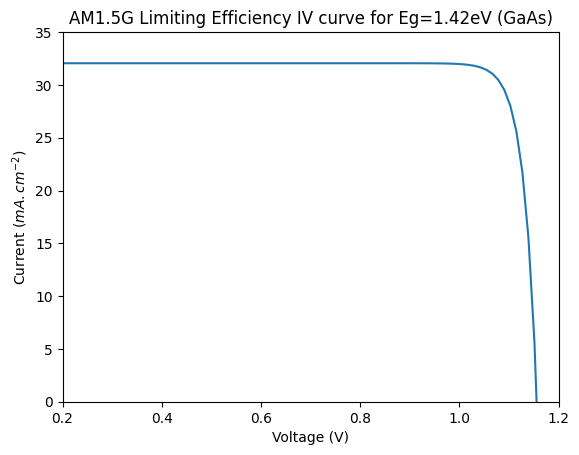

In [13]:
def getJ(v,eg):
    return getJsc(eg) - getJ0(eg)*(np.exp(v/(k*t)) - 1)

eg = 1.42
v = np.linspace(0,1.2,100)
j = np.vectorize(getJ)(v,eg)

plt.figure(3)
plt.title('AM1.5G Limiting Efficiency IV curve for Eg=1.42eV (GaAs)')
plt.plot(v,j/10)  #convert to mA.cm^-2
plt.xlim(0.2, 1.2)
plt.ylim(0,35)
plt.xlabel('Voltage (V)')
plt.ylabel('Current ($mA.cm^{-2}$)')

## Calculating the electrical power curve and finding the maximum power

Text(0, 0.5, 'Power ($W.m^{-2}$)')

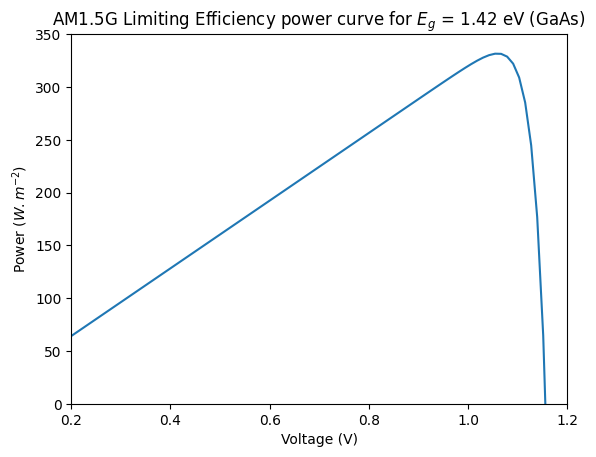

In [14]:
plt.figure()
plt.title('AM1.5G Limiting Efficiency power curve for $E_g$ = 1.42 eV (GaAs)')
plt.plot(v,v*j)
plt.xlim(0.2, 1.2)
plt.ylim(0,350)
plt.xlabel('Voltage (V)')
plt.ylabel('Power ($W.m^{-2}$)')

Define a function to find the maximum power point of the curve above:

In [15]:
def getPmax(eg):
    v = np.linspace(0,eg-0.1,500)
    p = v*np.vectorize(getJ)(v,eg)
    return (np.amax(p))  # The amax command returns the maximum value in the array p

Test it out on the curve above

In [16]:
getPmax(1.42)

331.6412760959975

### Plotting the Shockley-Queisser efficiency limit graph:

Finally we can calculate the Shockley-Queisser efficiency limit for AM1.5G

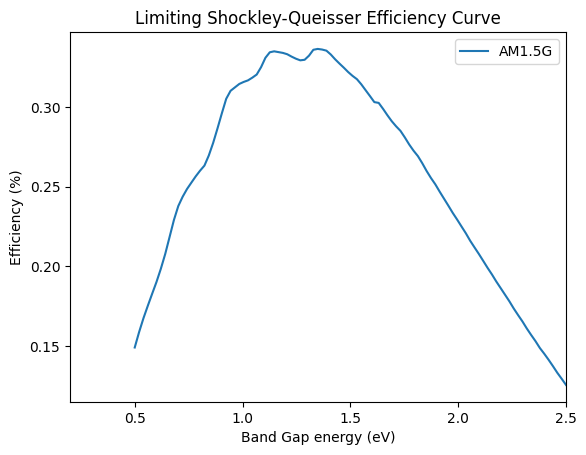

In [17]:
eg = np.linspace(0.5,2.5,100)
p = np.vectorize(getPmax)(eg)

plt.figure(3)
plt.title('Limiting Shockley-Queisser Efficiency Curve')
plt.plot(eg, p/b, label='AM1.5G')  # Remember b is the integrated power of the
# incident sunlight
plt.xlim(0.2, 2.5)
plt.xlabel('Band Gap energy (eV)')
plt.ylabel('Efficiency (%)')
plt.legend()

## An easier way -- using Solcore!

The Solcore library has all the functions we have written above built into it.  We worked through this example step by step, but we can calculate the same result using the code below.  First let's calculate an IV curve for a Shockley-Queisser solar cell with a band-gap of 1.42eV:

/Users/z3533914/.pyenv/versions/3.11.5/lib/python3.11/site-packages/solcore/registries.py:73: UserWarning: Optics solver 'RCWA' will not be available. An installation of S4 has not been found.
  warn(


Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


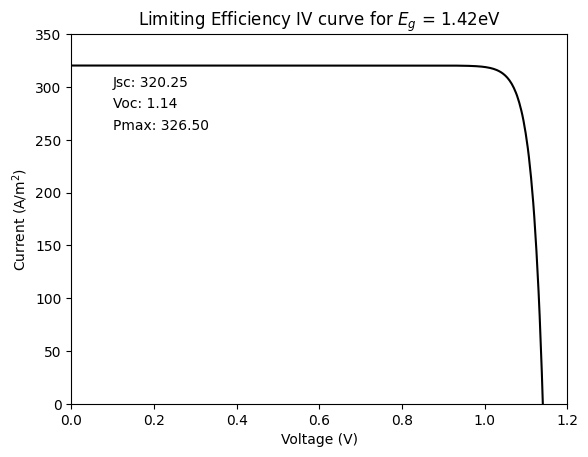

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from solcore.light_source import LightSource
from solcore.solar_cell import SolarCell
from solcore.solar_cell_solver import solar_cell_solver
from solcore.structure import Junction

# Load the AM1.5G solar spectrum
wl = np.linspace(300, 4000, 4000) * 1e-9    # wl contains the x-coordinate in wavelength
am15g = LightSource(source_type='standard', x=wl, version='AM1.5g')

eg = 1.42
V = np.linspace(0, 1.3, 500)
db_junction = Junction(kind='DB', T=300, Eg=eg, A=1, R_shunt=np.inf, n=1) #
# detailed-balance junction (Shockley-Queisser limit)

my_solar_cell = SolarCell([db_junction], T=300, R_series=0)

solar_cell_solver(my_solar_cell, 'iv',
                      user_options={'T_ambient': 300, 'db_mode': 'top_hat', 'voltages': V, 'light_iv': True,
                                    'internal_voltages': np.linspace(0, 1.3, 400), 'wavelength': wl,
                                    'mpp': True, 'light_source': am15g})

plt.figure()
plt.title('Limiting Efficiency IV curve for $E_g$ = 1.42eV')
plt.plot(V, my_solar_cell.iv.IV[1], 'k')
plt.ylim(0, 350)
plt.xlim(0, 1.2)
plt.text(0.1,300,f'Jsc: {my_solar_cell.iv.Isc:.2f}')
plt.text(0.1,280,f'Voc: {my_solar_cell.iv.Voc:.2f}')
plt.text(0.1,260,f'Pmax: {my_solar_cell.iv.Pmpp:.2f}')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A/m$^2$)')
plt.show()

The Shockley-Queisser efficiency calculation can now be performed over a range of band-gap energies.  To do this, we make a function that calculates the maximum power Pmax as a function of band-gap energy.

In [19]:
%%capture
# A command that prevents the screen from filling up with unnecessary working

# Function that returns the maximum power for a Shockley-Queisser solar cell with band-gap Eg
def getPmax(eg):
    V = np.linspace(0, eg-0.1, 500)
    db_junction = Junction(kind='DB', T=300, Eg=eg, A=1, R_shunt=np.inf, n=1)
    my_solar_cell = SolarCell([db_junction], T=300, R_series=0)

    solar_cell_solver(my_solar_cell, 'iv',
                      user_options={'T_ambient': 300, 'db_mode': 'top_hat', 'voltages': V, 'light_iv': True, 'wavelength': wl,
                                    'mpp': True, 'light_source': am15g})
    return(my_solar_cell.iv.Pmpp)

# Define the range of band-gaps to perform the calculation over
eg=np.linspace(0.5,2.5,100)
# Perform the claculation for all values of eg
p=np.vectorize(getPmax)(eg)

Now let's plot the result:

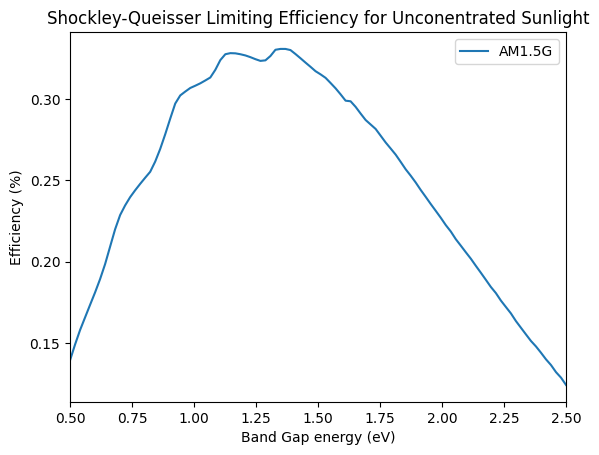

In [20]:
plt.figure()  # Plot the results calculated above:
plt.title('Shockley-Queisser Limiting Efficiency for Unconentrated Sunlight')
plt.plot(eg, p/am15g.power_density,label='AM1.5G')
plt.xlim(0.5, 2.5)
plt.xlabel('Band Gap energy (eV)')
plt.ylabel('Efficiency (%)')
plt.legend()

### Effect of solar concentration on a Shockley-Queisser Solar Cell

In a Trivich-Flinn model for a solar cell, concentrated sunlight is only expected to
increase the current of a solar cell, not the voltage.  In that model the current would increase in proportion with the concentration so the efficiency of the solar cell would be unchanged.

In the Shockley-Queisser model, concentrated sunlight increased both the current and
the voltage of the solar cell which, in the absence of series resistance losses, leads to an increase in the efficiency of the solar cell.  Here we calculate the Shockley-Queisser efficiency at different solar concentrations under the direct solar spectrum AM1.5D:

In [21]:
%%capture

# Set up a series of AM1.5D solar spectra at different concentrations
wl = np.linspace(300, 4000, 4000) * 1e-9    #wl contains the x-ordinate in wavelength
am15d1x = LightSource(source_type='standard', x=wl, version='AM1.5d', concentration=1)
am15d30x = LightSource(source_type='standard', x=wl, version='AM1.5d', concentration=30)
am15d1000x = LightSource(source_type='standard', x=wl, version='AM1.5d',
                         concentration=1000)

#Define a function to find Pmax for a particular band-gap energy and solar spectrum
def getPmax(eg,spectrum):
    V = np.linspace(0, eg-0.1, 500)
    db_junction = Junction(kind='DB', T=300, Eg=eg, A=1, R_shunt=np.inf, n=1)
    my_solar_cell = SolarCell([db_junction], T=300, R_series=0)

    solar_cell_solver(my_solar_cell, 'iv',
                      user_options={'T_ambient': 300, 'db_mode': 'top_hat', 'voltages': V, 'light_iv': True, 'wavelength': wl,
                                    'mpp': True, 'light_source': spectrum})
    return my_solar_cell.iv.Pmpp

# Evaluate the Pmax function for band-gaps spanning 0.8 to 1.6eV and concentrations 1x,30x,1000x
eg = np.linspace(0.8,1.6,100)
p1x = np.vectorize(getPmax)(eg, am15d1x)
p30x = np.vectorize(getPmax)(eg, am15d30x)
p1000x = np.vectorize(getPmax)(eg, am15d1000x)

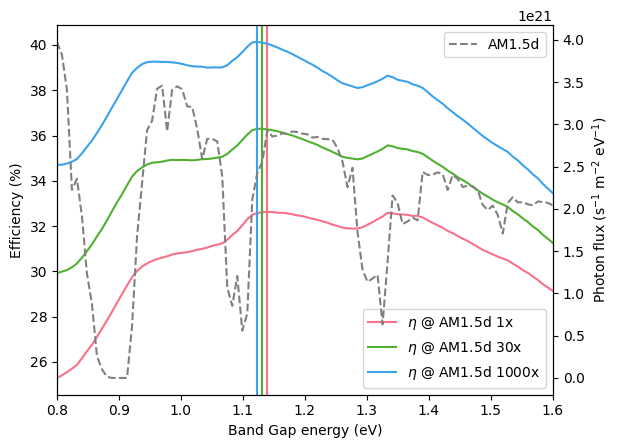

In [22]:
# Setup a figure for dual y-axes
fig, ax = plt.subplots(1)

# Plot the SQ curves
colors = sns.color_palette('husl', n_colors=3)
ax.plot(eg, 100*p1x/am15d1x.power_density,label='$\eta$ @ AM1.5d 1x', color=colors[0])
ax.axvline(eg[np.argmax(p1x)], color=colors[0])

ax.plot(eg, 100*p30x/am15d30x.power_density,label='$\eta$ @ AM1.5d 30x', color=colors[1])
ax.axvline(eg[np.argmax(p30x)], color=colors[1])

ax.plot(eg, 100*p1000x/am15d1000x.power_density,label='$\eta$ @ AM1.5d 1000x', color=colors[2])
ax.axvline(eg[np.argmax(p1000x)], color=colors[2])

# Define the second y-axis and plot the photon flux in units of eV
ax2 = ax.twinx()
ax2.plot(eg, am15d1x.spectrum(x=eg, output_units="photon_flux_per_ev")[1],
         '--', color='grey', label="AM1.5d")

ax.set_xlim(0.8, 1.6)
ax.set_xlabel('Band Gap energy (eV)')
ax.set_ylabel('Efficiency (%)')
ax2.set_ylabel(r'Photon flux (s$^{-1}$ m$^{-2}$ eV$^{-1}$)')
ax.legend()
ax2.legend()

The maximum band-gap energy moves to lower energies with increaseing solar concentration.  This arises since although the current increases with increasing solar concentration, the cell voltage also increases which means the optimal effiicency is obtained at lower band-gaps.  However, the drop in band-gap energy is modest owing to a strong atmospheric absorption feature at 1.1um which serves to pin the optimum bandgap around 1.12eV.

### Exercise: Concentrated AM0

Try repeating the example above but use the AM0 extraterrestial spectrum.  Observe what happens to the band-gap shift with increasing concentration.  How is it different to AM1.5d?